# Analyzing Training, Validation, and Testing Sets

Investigation of the dataset for new reflector short tank data

In [24]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Add the path to the parent directory to augment search for module

if "../.." not in sys.path:
    print("adding pardir")
    sys.path.append("../..")

from WatChMaL_analysis.old_reflector_short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

# Load Data From H5

In [27]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


# Load Indices

In [28]:
idxs_path = './short_dataset_data/equal_indices.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

# Split Datasets

In [29]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 'angles':test_angles, 'labels':test_labels}

print("Done test info")

Done train info
Done val info
Done test info


In [30]:
# compute and save event radii
"""
train_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]
val_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]
test_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]

np.savez('./short_dataset_data/event_radii.npz', train_radii=train_radius, val_radii=val_radius, test_radii=test_radius)
"""

"\ntrain_radius    = [np.sqrt(train_positions[i,0,0]**2 + train_positions[i,0,2]**2) for i in range(train_positions.shape[0])]\nval_radius     = [np.sqrt(val_positions[i,0,0]**2 + val_positions[i,0,2]**2) for i in range(val_positions.shape[0])]\ntest_radius    = [np.sqrt(test_positions[i,0,0]**2 + test_positions[i,0,2]**2) for i in range(test_positions.shape[0])]\n\nnp.savez('./short_dataset_data/event_radii.npz', train_radii=train_radius, val_radii=val_radius, test_radii=test_radius)\n"

In [31]:
radii_data = np.load('./short_dataset_data/event_radii.npz', allow_pickle=True)

train_info['radius'] = radii_data['train_radii']
val_info['radius']   = radii_data['val_radii']
test_info['radius']  = radii_data['test_radii']

In [32]:
dataset_info = [train_info, val_info, test_info]

# Get indices associated with each dataset and particle type

In [33]:

train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

# Initialize Detector Geometry Parameters

In [34]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

# Distribution of total charge

In [35]:
"""
pbar = ProgressBar(widgets=['Calculating Event Total Charge. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))

pbar.start()
done=0
for dset in dataset_info:
    total_charge = []
    for i in range(dset['positions'].shape[0]):
        pbar.update(done + i)
        
        item = train_idxs[i]
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        charge = hit_charge[start:stop]

        total_charge.append(np.sum(charge))
        
    dset['total_charge'] = total_charge
    done = done + dset['positions'].shape[0]
pbar.finish()

np.savez('./short_dataset_data/total_charge.npz',   train_total_charge= dataset_info[0]['total_charge'],
                                                    val_total_charge  = dataset_info[1]['total_charge'],
                                                    test_total_charge = dataset_info[2]['total_charge'])
"""

"\npbar = ProgressBar(widgets=['Calculating Event Total Charge. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))\n\npbar.start()\ndone=0\nfor dset in dataset_info:\n    total_charge = []\n    for i in range(dset['positions'].shape[0]):\n        pbar.update(done + i)\n        \n        item = train_idxs[i]\n        start = event_hits_index[item]\n        stop  = event_hits_index[item + 1]\n        charge = hit_charge[start:stop]\n\n        total_charge.append(np.sum(charge))\n        \n    dset['total_charge'] = total_charge\n    done = done + dset['positions'].shape[0]\npbar.finish()\n\nnp.savez('./short_dataset_data/total_charge.npz',   train_total_charge= dataset_info[0]['total_charge'],\n                                                    val_total_charge  = dataset_info[1]['total_charge'],\n                                                    test_

In [36]:
total_charge = np.load('./short_dataset_data/total_charge.npz', allow_pickle=True)

dataset_info[0]['total_charge'] = total_charge['train_total_charge']
dataset_info[1]['total_charge'] = total_charge['val_total_charge']
dataset_info[2]['total_charge'] = total_charge['test_total_charge']

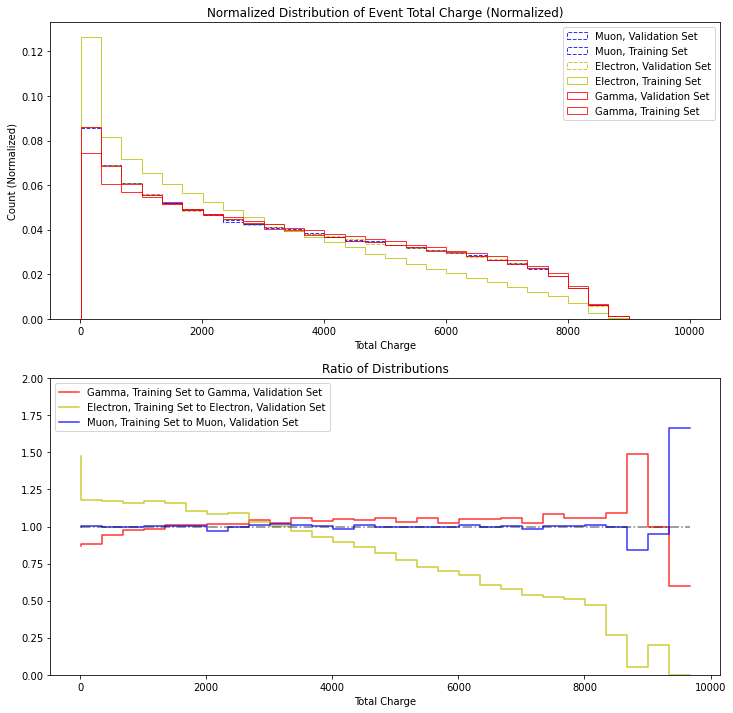

In [37]:
# plot total charge for different datasets
fig = plot_compare_dists([
                    dataset_info[0]['total_charge'][train_g_idxs], dataset_info[1]['total_charge'][val_g_idxs],
                    dataset_info[0]['total_charge'][train_m_idxs], dataset_info[1]['total_charge'][val_m_idxs],
                    dataset_info[1]['total_charge'][val_e_idxs], dataset_info[0]['total_charge'][train_e_idxs]],
                    bins=30,
                    numerator_dist_idxs   = [0,2,4],
                    denominator_dist_idxs = [1,3,5],
                    labels= ['Gamma, Training Set', 'Gamma, Validation Set',
                             'Electron, Training Set', 'Electron, Validation Set',
                             'Muon, Training Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],title='Normalized Distribution of Event Total Charge',
                    colors=['r','r','y','y','b','b'],
                    linestyle=['-','-','-','--','--','--'],
                    xlabel='Total Charge'
                    )

# Max Charge

In [38]:
"""
pbar = ProgressBar(widgets=['Calculating Event Max Charge. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))

pbar.start()
done=0
for dset in dataset_info:
    max_charge = []
    for i in range(dset['positions'].shape[0]):
        pbar.update(done + i)
        
        item = train_idxs[i]
        start = event_hits_index[item]
        stop  = event_hits_index[item + 1]
        charge = hit_charge[start:stop]

        max_charge.append(np.max(charge))
        
    dset['max_charge'] = max_charge
    done = done + dset['positions'].shape[0]
pbar.finish()

np.savez('./short_dataset_data/max_charge.npz', train_max_charge = dataset_info[0]['max_charge'],
                                                val_max_charge   = dataset_info[1]['max_charge'],
                                                test_max_charge  = dataset_info[2]['max_charge'])
"""

"\npbar = ProgressBar(widgets=['Calculating Event Max Charge. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))\n\npbar.start()\ndone=0\nfor dset in dataset_info:\n    max_charge = []\n    for i in range(dset['positions'].shape[0]):\n        pbar.update(done + i)\n        \n        item = train_idxs[i]\n        start = event_hits_index[item]\n        stop  = event_hits_index[item + 1]\n        charge = hit_charge[start:stop]\n\n        max_charge.append(np.max(charge))\n        \n    dset['max_charge'] = max_charge\n    done = done + dset['positions'].shape[0]\npbar.finish()\n\nnp.savez('./short_dataset_data/max_charge.npz', train_max_charge = dataset_info[0]['max_charge'],\n                                                val_max_charge   = dataset_info[1]['max_charge'],\n                                                test_max_charge  = dataset_info[2

In [39]:
max_charge = np.load('./short_dataset_data/max_charge.npz', allow_pickle=True)

dataset_info[0]['max_charge'] = max_charge['train_max_charge']
dataset_info[1]['max_charge'] = max_charge['val_max_charge']
dataset_info[2]['max_charge'] = max_charge['test_max_charge']

Bins:  [1.2243755e+00 9.0088974e+01 1.7895357e+02 2.6781818e+02 3.5668277e+02
 4.4554736e+02 5.3441199e+02 6.2327655e+02 7.1214117e+02 8.0100580e+02
 8.8987036e+02 9.7873499e+02 1.0675996e+03 1.1564641e+03 1.2453287e+03
 1.3341934e+03 1.4230580e+03 1.5119226e+03 1.6007871e+03 1.6896517e+03
 1.7785164e+03 1.8673810e+03 1.9562456e+03 2.0451101e+03 2.1339749e+03
 2.2228394e+03 2.3117039e+03 2.4005686e+03 2.4894331e+03 2.5782979e+03
 2.6671624e+03]


../../WatChMaL_analysis/old_reflector_short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:159: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../WatChMaL_analysis/old_reflector_short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../WatChMaL_analysis/old_reflector_short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:159: RuntimeWarning: divide by zero encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../WatChMaL_analysis/old_reflector_short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:159: RuntimeWarning: invalid value encountered in true_divide
  ns[idx] / ns[denominator_dist_idxs[i]],
../../WatChMaL_analysis/old_reflector_short_tank_exploratory_data_analysis/exploratory_data_analysis_utils.py:159: RuntimeWarning: invalid val

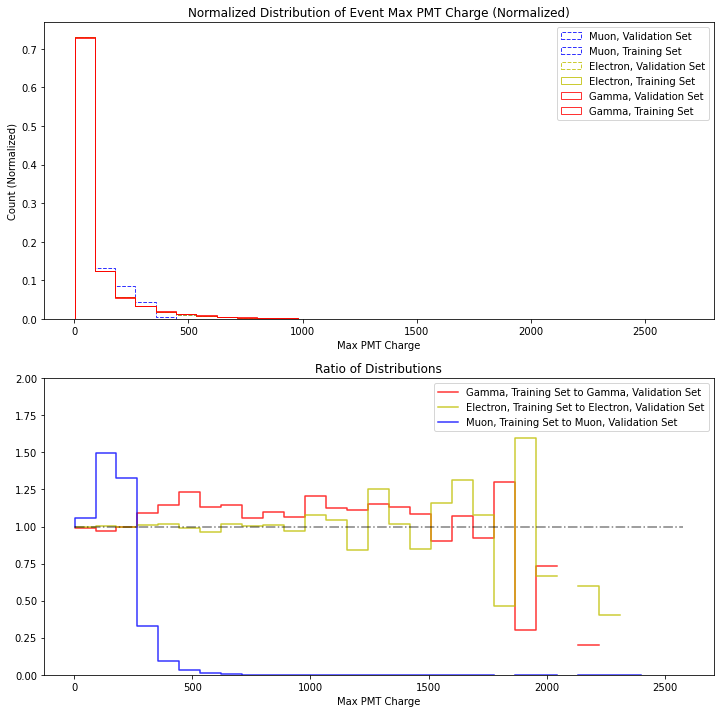

In [40]:
fig = plot_compare_dists([
                    dataset_info[0]['max_charge'][train_g_idxs], dataset_info[1]['max_charge'][val_g_idxs],
                    dataset_info[0]['max_charge'][train_e_idxs], dataset_info[1]['max_charge'][val_e_idxs],
                    dataset_info[0]['max_charge'][train_m_idxs], dataset_info[1]['max_charge'][val_m_idxs]],
                    bins=30,
                    numerator_dist_idxs   = [0,2,4],
                    denominator_dist_idxs = [1,3,5],
                    labels=['Gamma, Training Set', 'Gamma, Validation Set',
                            'Electron, Training Set', 'Electron, Validation Set',
                            'Muon, Training Set', 'Muon, Validation Set'],
                    ratio_range=[0,2],
                    title='Normalized Distribution of Event Max PMT Charge',
                    colors=['r','r','y','y','b','b'],
                    linestyle=['-','-','-','--','--','--'],
                    xlabel='Max PMT Charge',
                    verbose=True
                    )